In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/pruning_quantization", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets, get_subset
from model_config import MLP_Models, LSTM_Models, GRU_Models, CNN_models
from utils.benchmark import Benchmark
from compact.quantization import dynamic_quantize, static_quantization
import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
conf = Config()
#load_model = MLP_Models()
#load_model = LSTM_Models()
#load_model = GRU_Models()
load_model = CNN_models()
model_conf = load_model.cnn_4
model = load_model.get_model(model_conf)
model.load()
print(conf.device)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/cnn_4.pth!
cpu


In [3]:
# data loader
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, model_type=load_model.type)

# create train dataloader
train_dataset = NetworkDataset(X_train, y_train)

# create test dataloader
dataset = NetworkDataset(X_test, y_test)
subset, length = get_subset(dataset, y_test)
loader = DataLoader(subset, conf.batch_size, shuffle=True)
assert conf.batch_size < length

train_dataset_no_aug = copy.deepcopy(train_dataset)
calibration_loader = DataLoader(train_dataset_no_aug, batch_size=conf.batch_size, shuffle=False)

In [ ]:
fp32_model = model.model
fp32_model.cpu()
fp32_model.eval()

if load_model.type == "rnn":
    int8_model = dynamic_quantize(fp32_model, arch="arm")

else:
    if load_model.type == "mlp":
        fp32_modules = ["embedding", "ln1", "output"] # mlp modules
        example_input = torch.randn(1, 513) # mlp
    elif load_model.type == "cnn":
        fp32_modules = ["embedding", "ln1", "ln2", "output"] # cnn modules
        example_input = torch.randn(1, 1, 513) # cnn
    else:
        raise ValueError("Model type not recognized!")
    
    int8_model = static_quantization(fp32_model, calibration_loader, fp32_modules, example_input, arch="arm")

In [5]:
print(int8_model)
model.model = int8_model

GraphModule(
  (conv): Module(
    (0): Module(
      (0): QuantizedConv1d(1, 32, kernel_size=(23,), stride=(1,), scale=1.3425045013427734, zero_point=59)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Module(
      (0): QuantizedConv1d(32, 64, kernel_size=(19,), stride=(1,), scale=0.607191801071167, zero_point=73)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Module(
      (0): QuantizedConv1d(64, 128, kernel_size=(15,), stride=(1,), scale=0.2501200735569, zero_point=81)
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): QuantizedDropout(p=0.2, inplace=False)
    )
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Module(
      (0

Warmup Done!
Memory Benchmark Done!


ERROR:2026-01-29 17:11:33 3909567:3909567 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


Latency Benchmark Done!
Throughput Benchmark Done!
CPU Benchmark Done!
Metrics Benchmark Done!


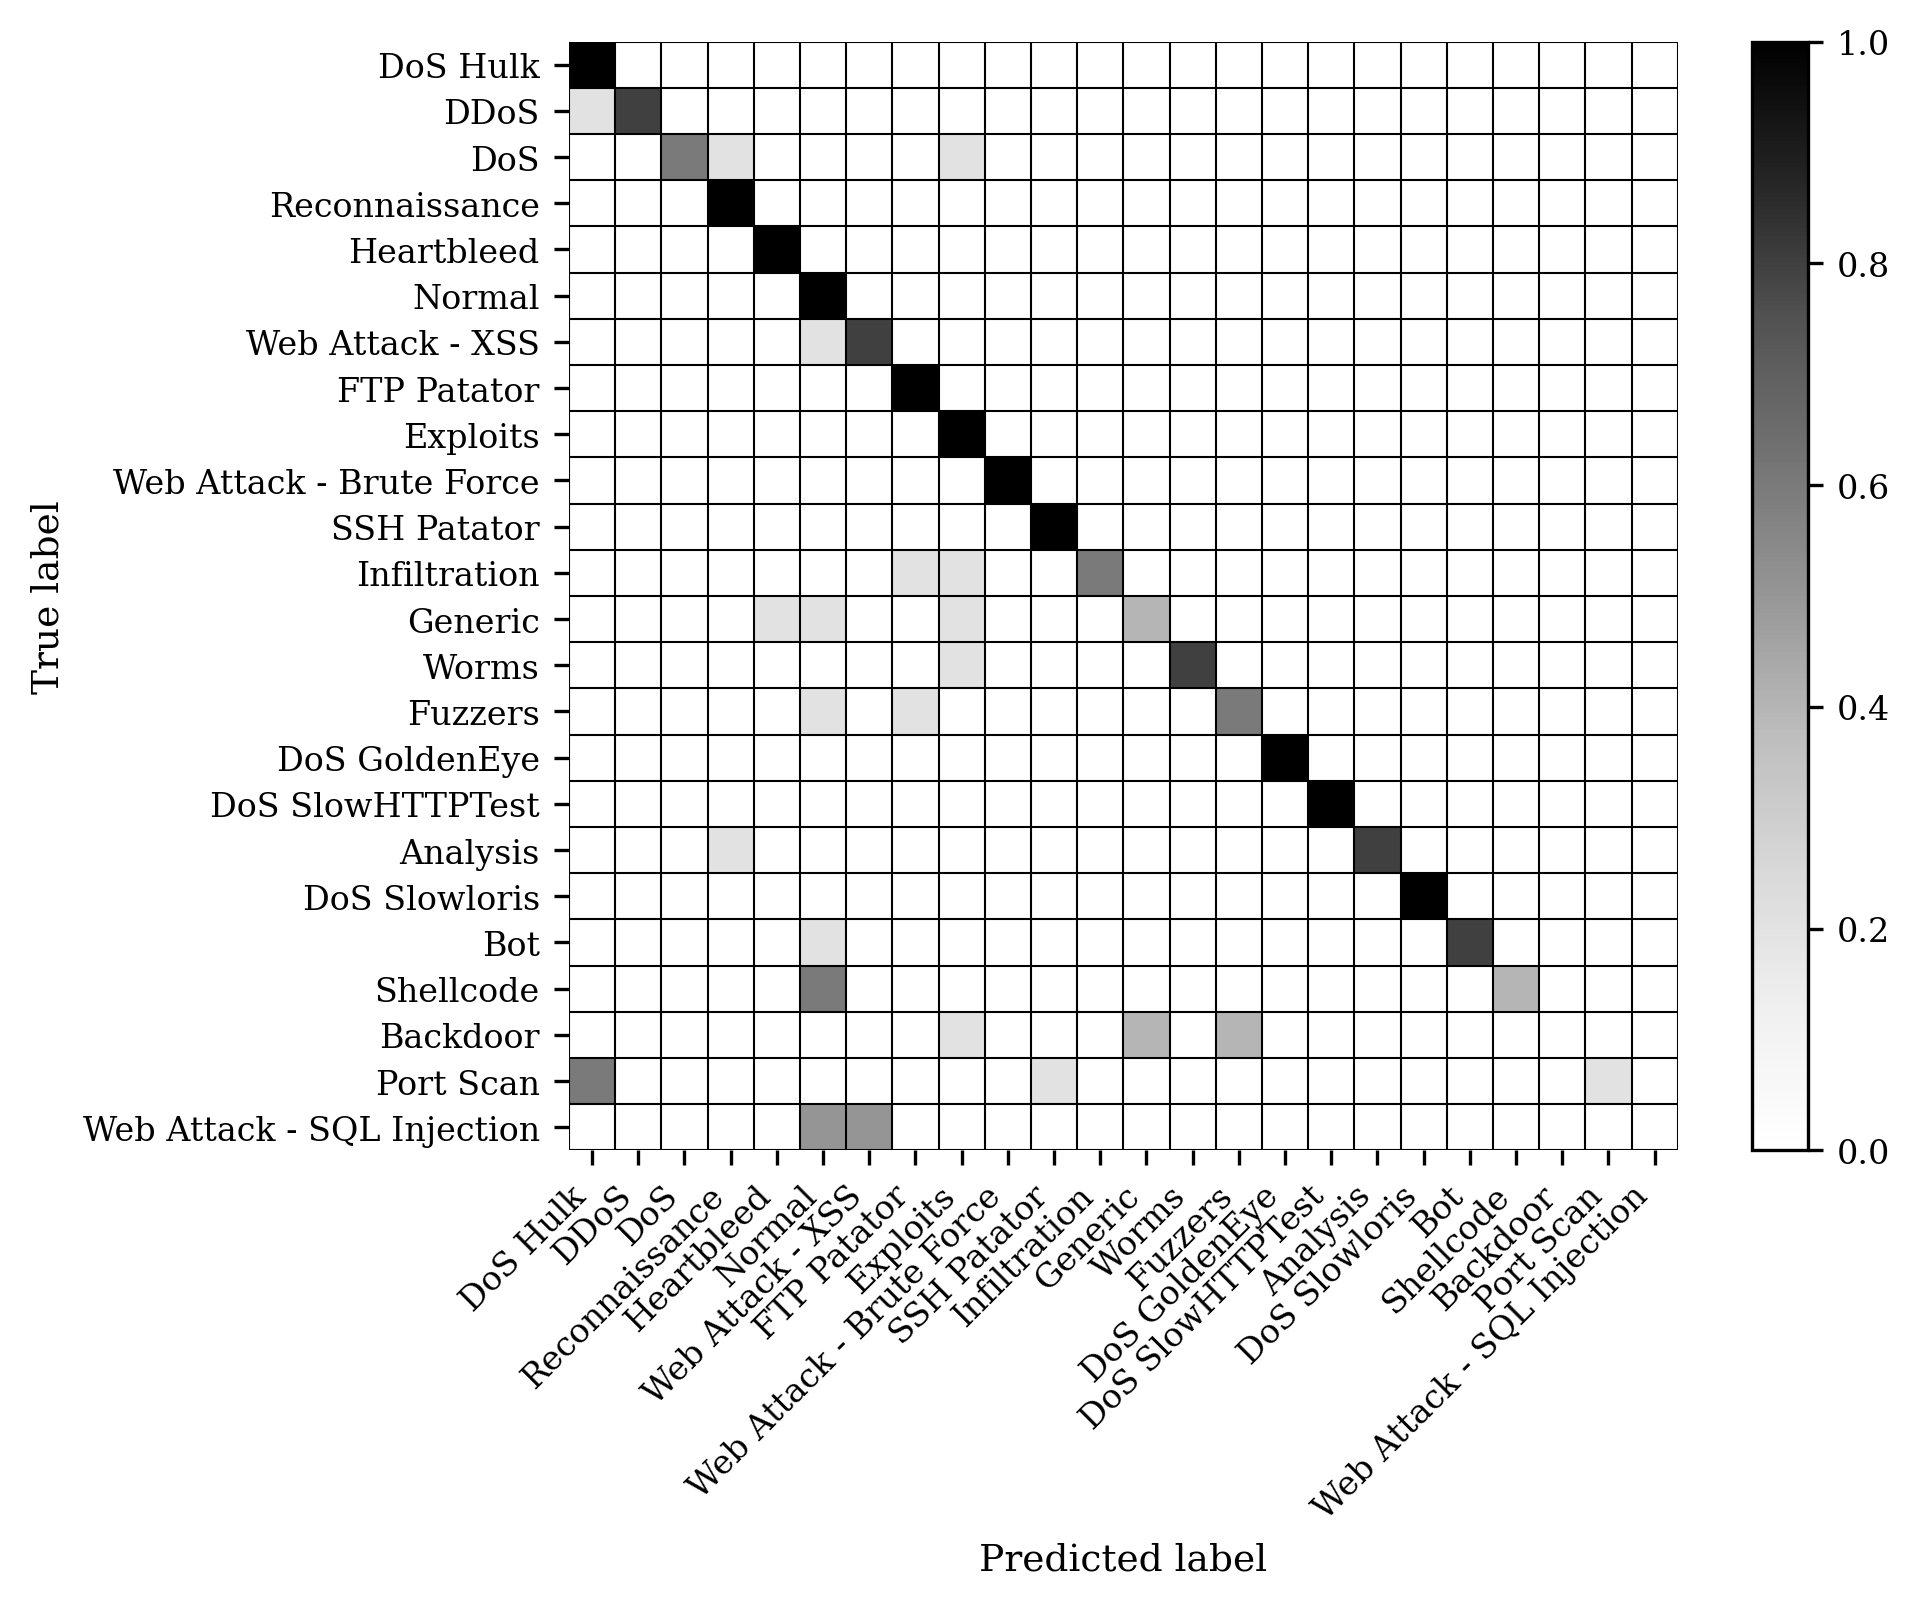

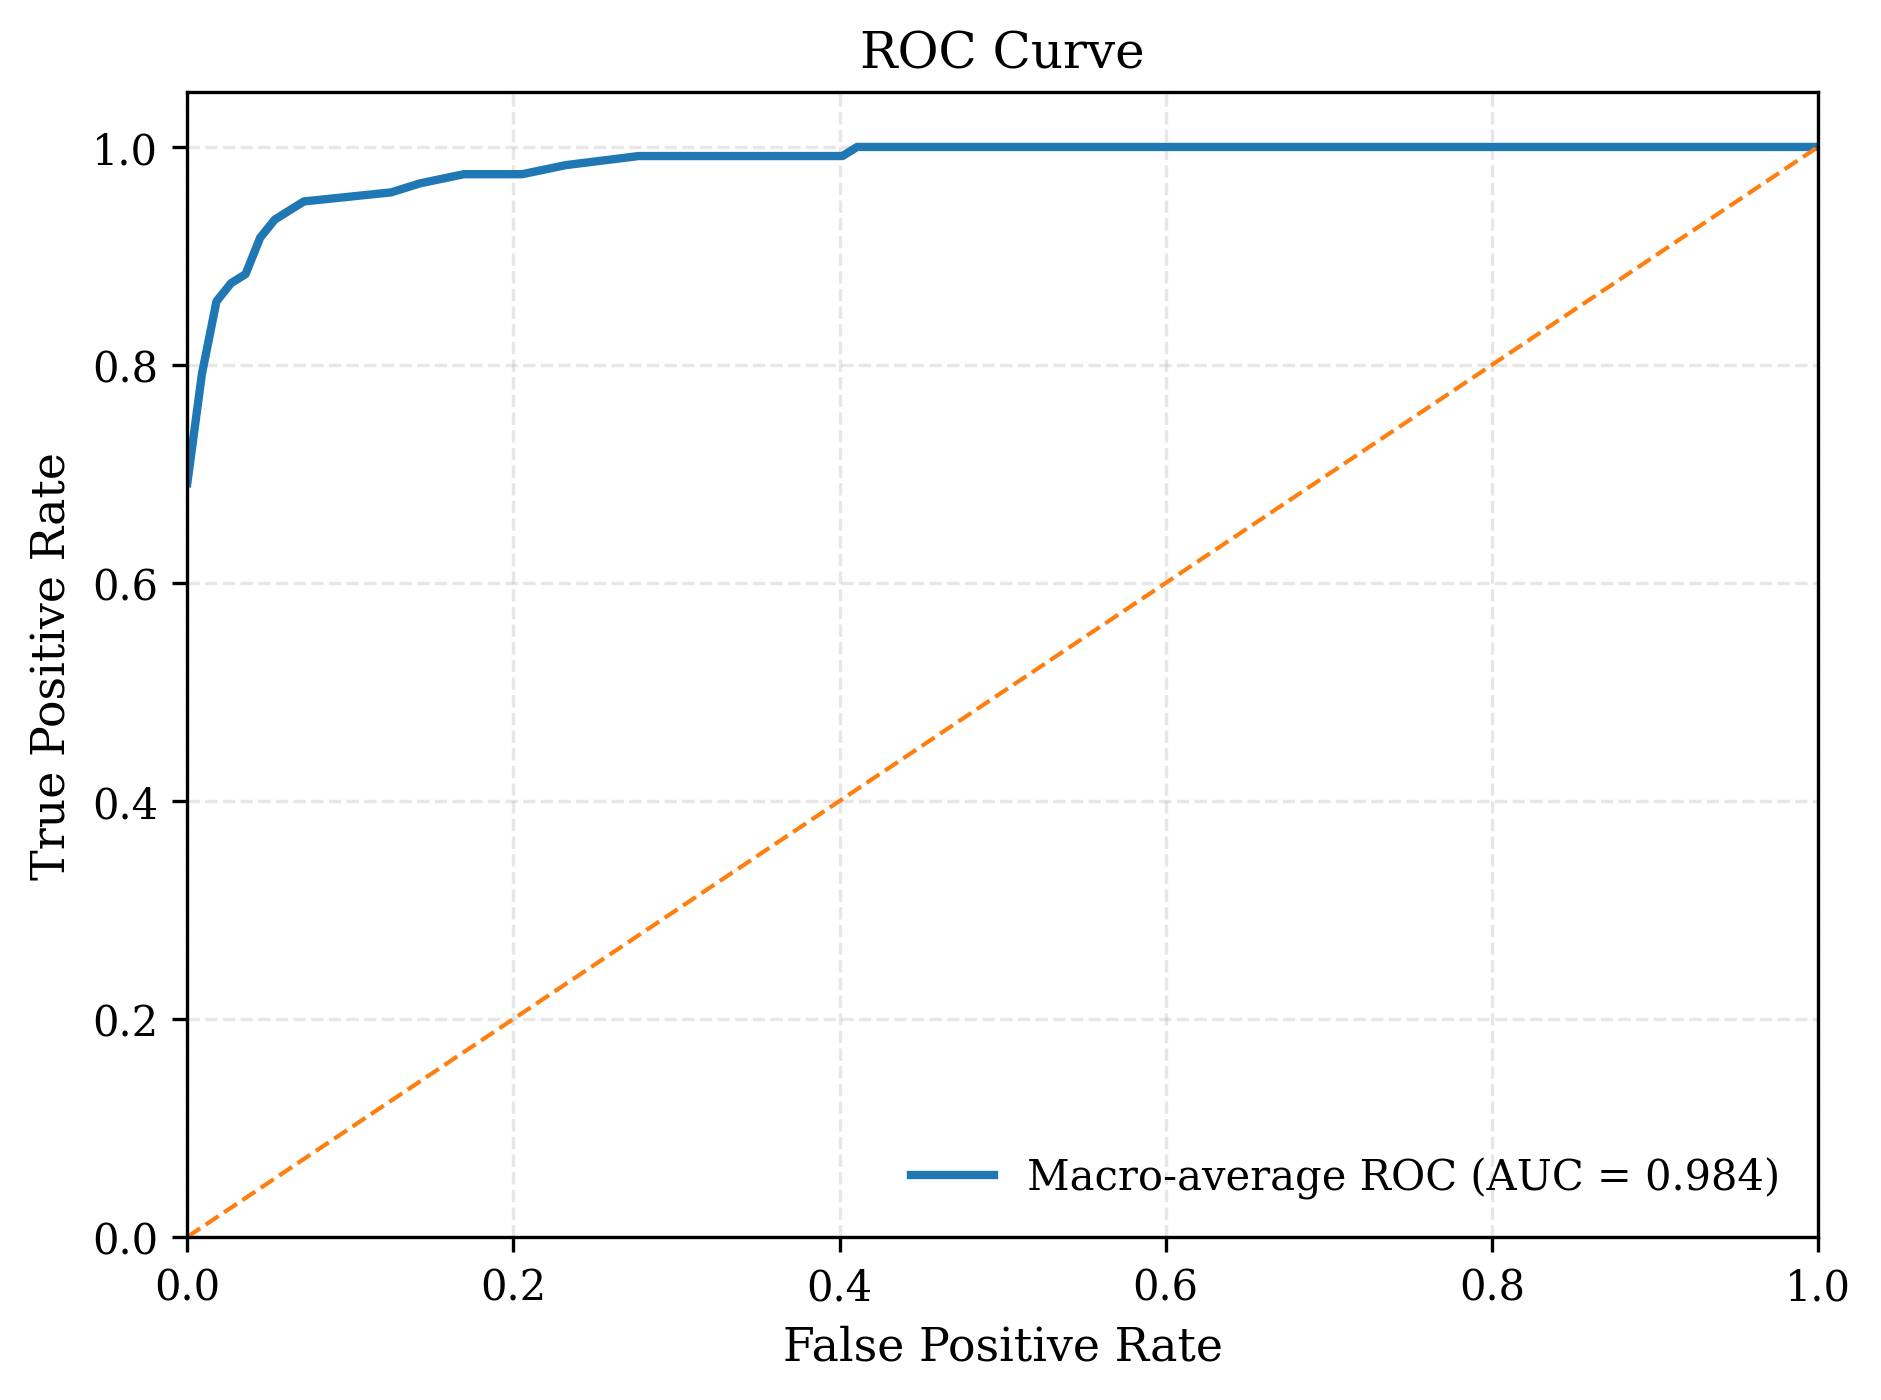

,Section,Metric,Value
0,Info,Name,quant_cnn_4
1,Info,Batch Size,1
2,Info,Samples,117
3,Info,Location,Host
4,Memory,Avg. (MB),0.126
5,Memory,Peak (MB),2.353
6,Memory,Model (MB),0.051
7,Latency,Total (ms),163.529
8,Latency,Avg. (ms),1.398
9,Latency,Min (ms),1.347


In [ ]:
# benchmark model
name = "quant_" + model_conf["name"]
result_path = os.path.join(conf.benchmark_dpu, "pruned_quantized_model", name + ".csv")
plot_path = os.path.join(conf.plot, conf.location, "pruned_quantized_model")

benchmark = Benchmark(model, loader, conf.batch_size, name, result_path, runs=length)
benchmark(plot=True, plot_path=plot_path)

# print and save result
benchmark.print_result()
benchmark.save()